# Задача
### Требуется на основании имеющихся данных о клиентах банка построить модель прогнозирования невыполнения долговых обязательств по текущему кредиту. 
### Выполнить прогноз для примеров из тестового датасета.

## Наименование файлов с данными:
	train_data.csv - обучающий датасет
	test_data.csv - тестовый датасет

## Описание датасета
	* Home Ownership - домовладение
	* Annual Income - годовой доход
	* Years in current job - количество лет на текущем месте работы
	* Tax Liens - налоговое обременение
	* Number of Open Accounts - количество открытых счетов
	* Years of Credit History - количество лет кредитной истории
	* Maximum Open Credit - наибольший открытый кредит
	* Number of Credit Problems - количество проблем с кредитом
	* Months since last delinquent - количество месяцев с последней просрочки платежа
	* Bankruptcies - банкротства
	* Purpose - цель кредита
	* Term - срок кредита
	* Current Loan Amount - текущая сумма кредита
	* Current Credit Balance - текущий кредитный баланс
	* Monthly Debt - ежемесячный долг
	* Credit Score - кредитный рейтинг
	* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Целевая переменная:
	Credit Default - факт невыполнения кредитных обязательств

## Требования к решению:
	* F1(sklearn.metrics.f1_score) > 0.5 при Precision > 0.5 и Recall > 0.5
	* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

## Решение должно включать:
	1. Jupyter Notebook с кодом решения
	2. Файл CSV с прогнозами целевой переменной для тестового датасета

## Сроки: неделя с момента получения задания.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from catboost import CatBoostClassifier, Pool, cv


In [2]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


## Посмотрим на данные, с которыми предстоит работать

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64 


False    5943
True     1557
Name: Annual Income, dtype: int64 




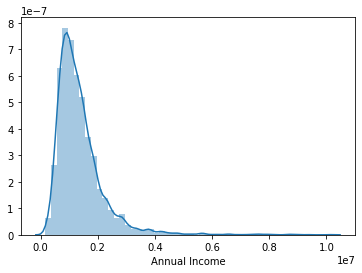

In [3]:
print(train_df['Home Ownership'].value_counts(), '\n\n')
print(train_df['Annual Income'].isna().value_counts(), '\n\n')
sns.distplot(train_df['Annual Income'].dropna())

In [4]:
trace1 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 1]['Annual Income'],
    name='Кредит просрочен',
    marker=dict(color='red',opacity=1)
)
trace2 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 0]['Annual Income'],
    name='Возвращен вовремя',
    marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
layout = go.Layout(title="Annual Income by Credit Default",
                   barmode='overlay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [5]:
print(train_df['Years in current job'].isna().value_counts(), '\n\n')

trace1 = go.Bar(
            x = train_df[train_df['Credit Default'] == 1]['Years in current job'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 1]['Years in current job'].value_counts().values,
            name='Кредит просрочен',
            marker=dict(color='red',opacity=0.5)
)
trace2 = go.Bar(
            x = train_df[train_df['Credit Default'] == 0]['Years in current job'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 0]['Years in current job'].value_counts().values,
            name='Возвращен вовремя',
            marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Years of exp distribution by Credit Default",
    xaxis=dict(title='Years',tickangle=-60),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

False    7129
True      371
Name: Years in current job, dtype: int64 




In [6]:
trace1 = go.Bar(
            x = train_df[train_df['Credit Default'] == 1]['Number of Open Accounts'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 1]['Number of Open Accounts'].value_counts().values,
            name='Кредит просрочен',
            marker=dict(color='red',opacity=0.5)
)
trace2 = go.Bar(
            x = train_df[train_df['Credit Default'] == 0]['Number of Open Accounts'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 0]['Number of Open Accounts'].value_counts().values,
            name='Возвращен вовремя',
            marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Open Accounts distribution by Credit Default",
    xaxis=dict(title='Acc',tickangle=-60),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [7]:
trace1 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 1]['Years of Credit History'],
    name='Кредит просрочен',
    marker=dict(color='red',opacity=1)
)
trace2 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 0]['Years of Credit History'],
    name='Возвращен вовремя',
    marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
layout = go.Layout(title="Years of Credit History by Credit Default",
                   barmode='overlay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [8]:
trace1 = go.Bar(
            x = train_df[train_df['Credit Default'] == 1]['Number of Credit Problems'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 1]['Number of Credit Problems'].value_counts().values,
            name='Кредит просрочен',
            marker=dict(color='red',opacity=0.5)
)
trace2 = go.Bar(
            x = train_df[train_df['Credit Default'] == 0]['Number of Credit Problems'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 0]['Number of Credit Problems'].value_counts().values,
            name='Возвращен вовремя',
            marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Number of Credit Problems distribution by Credit Default",
    xaxis=dict(title='Acc',tickangle=0),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [9]:
trace1 = go.Bar(
            x = train_df[train_df['Credit Default'] == 1]['Bankruptcies'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 1]['Bankruptcies'].value_counts().values,
            name='Кредит просрочен',
            marker=dict(color='red',opacity=0.5)
)
trace2 = go.Bar(
            x = train_df[train_df['Credit Default'] == 0]['Bankruptcies'].value_counts().index.values,
            y = train_df[train_df['Credit Default'] == 0]['Bankruptcies'].value_counts().values,
            name='Возвращен вовремя',
            marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
    
layout = go.Layout(title="Number of Bankruptcies distribution by Credit Default",
    xaxis=dict(title='Acc',tickangle=0),
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [10]:
print(train_df['Months since last delinquent'].isna().value_counts(), '\n\n')

trace1 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 1]['Months since last delinquent'],
    name='Кредит просрочен',
    marker=dict(color='red',opacity=1)
)
trace2 = go.Histogram(
    x=train_df[train_df['Credit Default'] == 0]['Months since last delinquent'],
    name='Возвращен вовремя',
    marker=dict(color='green',opacity=0.5)
)

data = [trace1, trace2]
layout = go.Layout(title="Months since last delinquent",
                   barmode='overlay')
fig = go.Figure(data=data, layout=layout)
iplot(fig)

True     4081
False    3419
Name: Months since last delinquent, dtype: int64 




In [11]:
def plot_distribution(df, var, target, **kwargs):
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue = target, aspect = 4, row = row, col = col)
    facet.map(sns.kdeplot, var, shade = True)
    facet.set(xlim = (df[var].min(), df[var].max()))
    facet.add_legend()
    plt.show()


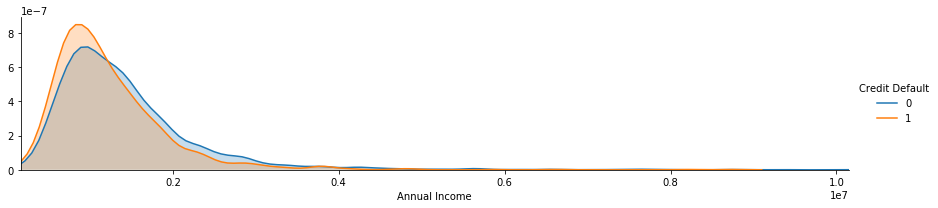

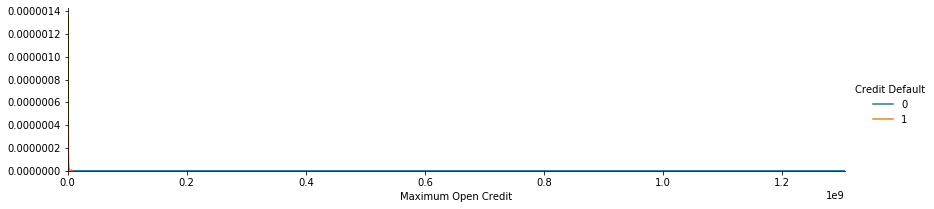

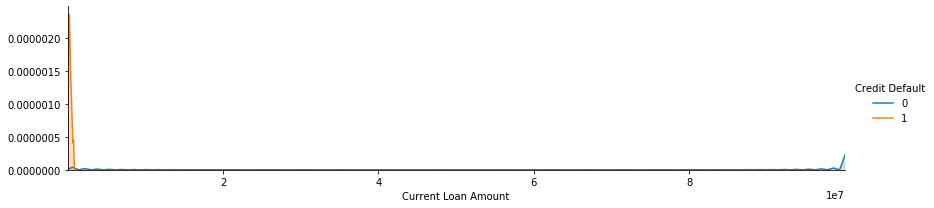

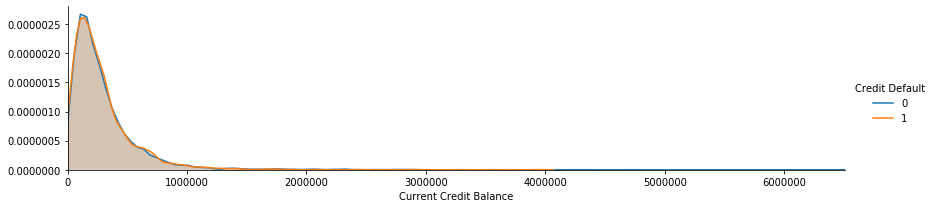

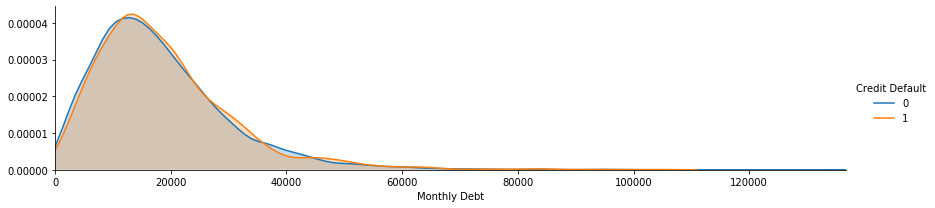

In [12]:
num_cols = ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount','Current Credit Balance', 'Monthly Debt']
for numy in num_cols:
    plot_distribution(train_df, numy, 'Credit Default')


In [13]:
train_df[train_df['Maximum Open Credit'] < train_df['Maximum Open Credit'].quantile(0.75)]['Maximum Open Credit'].describe()

count      5625.000000
mean     389654.363022
std      196383.708645
min           0.000000
25%      235026.000000
50%      370216.000000
75%      541574.000000
max      793430.000000
Name: Maximum Open Credit, dtype: float64

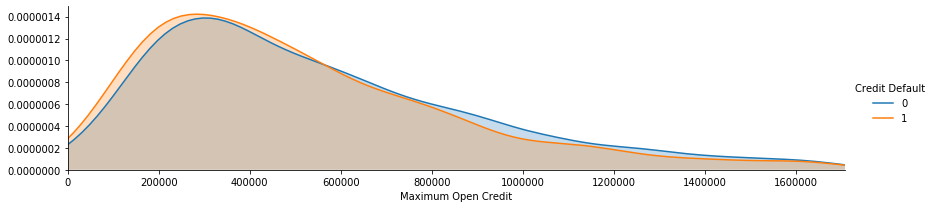

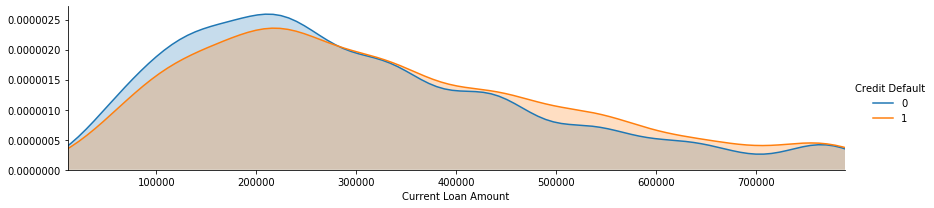

In [14]:
plot_distribution(train_df[train_df['Maximum Open Credit'] < train_df['Maximum Open Credit'].quantile(0.95)], 'Maximum Open Credit', 'Credit Default')
plot_distribution(train_df[train_df['Current Loan Amount'] < train_df['Current Loan Amount'].quantile(0.95)], 'Current Loan Amount', 'Credit Default')

## Попробуем обучить catboost classifier, ничего не делая с данными

In [15]:
categ_feat_idx = np.where(train_df.drop('Credit Default', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([ 0,  2, 10, 11], dtype=int64)

In [16]:
train_df['Years in current job'].fillna('Unemployed', inplace=True)
test_df['Years in current job'].fillna('Unemployed', inplace=True)

In [17]:
X_train = train_df.drop('Credit Default', axis=1).values
y_train = train_df['Credit Default'].values
X_test = test_df.values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [18]:
def print_score(clf, X_valid, y_valid):
    clf_valid_pred = clf.predict(X_valid)
    print('Precision is:', precision_score(y_valid, clf_valid_pred))
    print('Recall is:', recall_score(y_valid, clf_valid_pred))
    print('F1 score is:', f1_score(y_valid, clf_valid_pred))

In [19]:
%%time
ctb = CatBoostClassifier(random_seed=1, silent=True)
ctb.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);
print_score(ctb, X_valid, y_valid)

Precision is: 0.7454545454545455
Recall is: 0.3173374613003096
F1 score is: 0.4451682953311618
Wall time: 33 s


### Precision is: 0.7454545454545455
### Recall is: 0.3173374613003096
### F1 score is: 0.4451682953311618


#### Можно заметить, что классификатор подстраивается под нулевые метки, вероятно, из-за дисбаланса классов

## Feature Engineering

In [20]:
train_df['Current Loan Amount'].replace({max(train_df['Current Loan Amount']): np.nan}, inplace=True)
test_df['Current Loan Amount'].replace({max(test_df['Current Loan Amount']): np.nan}, inplace=True)

Text(0.5, 1.0, 'Years in current job by Annual Income')

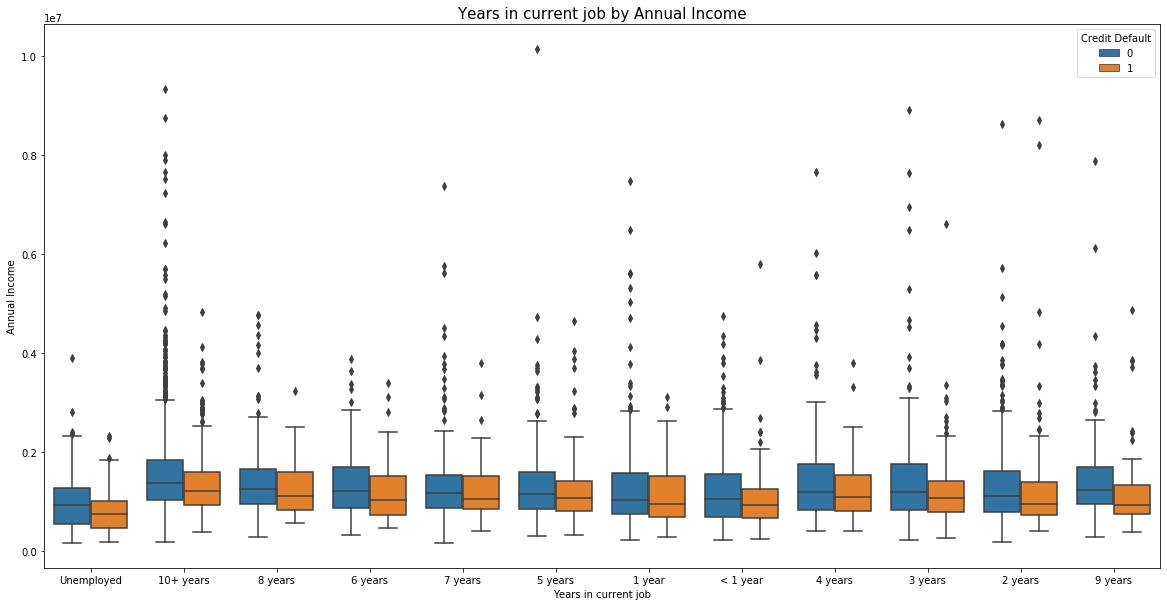

In [21]:
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x='Years in current job', y = 'Annual Income',ax = ax, data = train_df, hue = 'Credit Default' )
ax.set_title('Years in current job by Annual Income', size = 15)

In [22]:
train_df['Income by exp'] = train_df['Annual Income'].values /(1. + train_df.groupby(
    'Years in current job')['Annual Income'].mean().loc[train_df['Years in current job']].values)
test_df['Income by exp'] = test_df['Annual Income'].values /(1. + test_df.groupby(
    'Years in current job')['Annual Income'].mean().loc[test_df['Years in current job']].values)

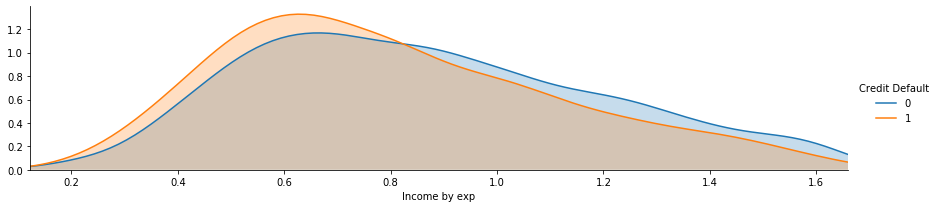

In [23]:
plot_distribution(train_df[train_df['Income by exp'] <
                           train_df['Income by exp'].quantile(0.9)], 'Income by exp', 'Credit Default')

In [24]:
train_df['income debt ratio'] = train_df['Annual Income'] / ((1. + train_df['Monthly Debt']) * 12)
test_df['income debt ratio'] = test_df['Annual Income'] / ((1. + test_df['Monthly Debt']) * 12)

In [25]:
train_df[train_df['income debt ratio'] > train_df['income debt ratio'].quantile(0.9)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Income by exp,income debt ratio
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,NaN,51623.0,2317.0,745.0,0,1.000337,54.325137
20,Home Mortgage,1651993.0,10+ years,0.0,11.0,26.5,663894.0,0.0,44.0,0.0,debt consolidation,Long Term,585090.0,252852.0,8742.0,697.0,0,1.093601,15.745863
60,Home Mortgage,1630029.0,Unemployed,0.0,10.0,17.3,697114.0,0.0,NaN,0.0,debt consolidation,Long Term,230362.0,260680.0,6181.0,714.0,0,1.764539,21.972784
67,Rent,1269333.0,< 1 year,0.0,7.0,15.8,235510.0,0.0,NaN,0.0,debt consolidation,Short Term,NaN,171874.0,5183.0,747.0,0,1.053630,20.404659
73,Home Mortgage,1631644.0,8 years,0.0,9.0,12.1,862422.0,0.0,NaN,0.0,other,Short Term,351670.0,155667.0,4773.0,718.0,1,1.173168,28.481427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7468,Home Mortgage,3084840.0,5 years,0.0,10.0,18.9,998910.0,0.0,NaN,0.0,debt consolidation,Long Term,519552.0,138890.0,4859.0,746.0,0,2.318058,52.895062
7477,Rent,1995000.0,3 years,0.0,16.0,21.0,816618.0,0.0,49.0,0.0,buy a car,Short Term,528000.0,29621.0,9559.0,750.0,1,1.428583,17.390167
7484,Home Mortgage,1258712.0,8 years,0.0,6.0,9.5,364210.0,0.0,NaN,0.0,debt consolidation,Short Term,161436.0,93100.0,4689.0,741.0,0,0.905026,22.365174
7486,Rent,5327372.0,1 year,0.0,7.0,12.1,605638.0,0.0,NaN,0.0,debt consolidation,Short Term,111760.0,292904.0,8080.0,750.0,0,4.198708,54.937219


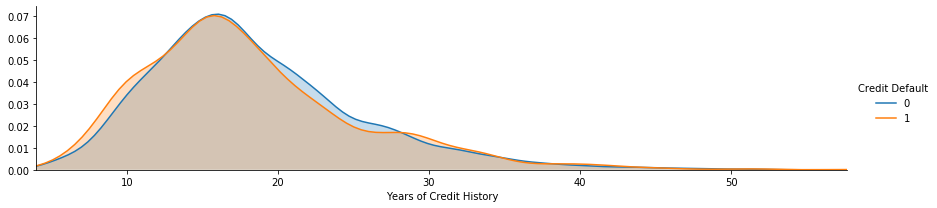

In [26]:
plot_distribution(train_df, 'Years of Credit History', 'Credit Default')

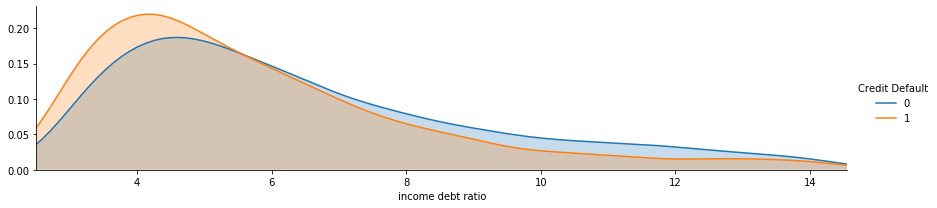

In [27]:
plot_distribution(train_df[train_df['income debt ratio'] <
                           train_df['income debt ratio'].quantile(0.9)], 'income debt ratio', 'Credit Default')

In [28]:
train_df['Time to Pay Out'] = train_df['Current Loan Amount'] / (1 + 12 * train_df['Monthly Debt'])
test_df['Time to Pay Out'] = train_df['Current Loan Amount'] / (1 + 12 * train_df['Monthly Debt'])

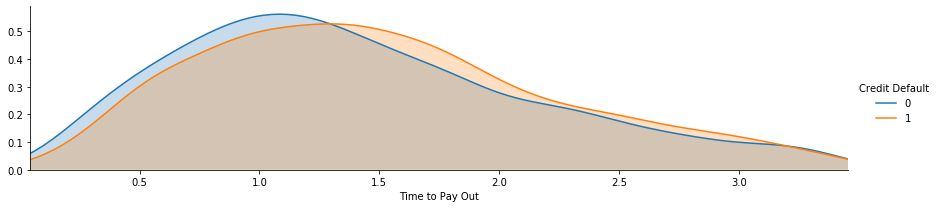

In [29]:
df_to_plot = train_df[train_df['Time to Pay Out'] < train_df['Time to Pay Out'].quantile(0.9)]
plot_distribution(df_to_plot, 'Time to Pay Out', 'Credit Default')

In [30]:
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Income by exp,income debt ratio,Time to Pay Out
0,Own Home,482087.0,Unemployed,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,NaN,47386.0,7914.0,749.0,0,0.521869,5.075669,NaN
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0.678861,4.650988,1.201794
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,NaN,308389.0,13651.0,742.0,0,0.540273,4.586703,NaN
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0.613745,5.916659,0.892244
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0.558142,9.008309,1.460522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0.333846,17.630721,5.673435
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,1.208992,9.999374,2.894763
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,NaN,477812.0,12479.0,748.0,0,1.432390,12.546140,NaN
7498,Home Mortgage,NaN,Unemployed,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,NaN,NaN,1.381344


In [31]:
categ_feat_idx_new = np.where(train_df.drop('Credit Default', axis=1).dtypes == 'object')[0]
categ_feat_idx_new

array([ 0,  2, 10, 11], dtype=int64)

In [32]:
X_train_new = train_df.drop('Credit Default', axis=1).values
y_train_new = train_df['Credit Default'].values
X_test_new = test_df.values

In [34]:
X_train_part_new, X_valid_new, y_train_part_new, y_valid_new = train_test_split(X_train_new, y_train_new, 
                                                                test_size=0.3, 
                                                                random_state=1)

In [35]:
%%time
ctb_new = CatBoostClassifier(random_seed=1, silent=True)
ctb_new.fit(X_train_part_new, y_train_part_new,
        cat_features=categ_feat_idx_new);

Wall time: 37.8 s


In [36]:
print_score(ctb_new, X_valid_new, y_valid_new)

Precision is: 0.7676056338028169
Recall is: 0.34222919937205654
F1 score is: 0.47339847991313794


## Oversampling

In [37]:
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Income by exp,income debt ratio,Time to Pay Out
0,Own Home,482087.0,Unemployed,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,NaN,47386.0,7914.0,749.0,0,0.521869,5.075669,NaN
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0.678861,4.650988,1.201794
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,NaN,308389.0,13651.0,742.0,0,0.540273,4.586703,NaN
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0.613745,5.916659,0.892244
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0.558142,9.008309,1.460522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0,0.333846,17.630721,5.673435
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1,1.208992,9.999374,2.894763
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,NaN,477812.0,12479.0,748.0,0,1.432390,12.546140,NaN
7498,Home Mortgage,NaN,Unemployed,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0,NaN,NaN,1.381344


In [38]:
def Oversampling(df, target):
    train, valid = train_test_split(df, 
                                    test_size=0.3, 
                                    random_state=1,
                                    stratify=df[target])
    count = len(train[train[target] == 0])
    df_oversampled = pd.concat([train[train[target]==0] , 
                              train[train[target]==1].sample(count, replace=True)])
    y_oversampled = df_oversampled[target].values
    X_oversampled = df_oversampled.drop(target, axis=1).values
    y_valid = valid[target].values
    X_valid = valid.drop(target, axis=1).values
    return X_oversampled, X_valid, y_oversampled, y_valid

In [39]:
X_oversampled, X_valid_oversampled, y_oversampled, y_valid_oversampled = Oversampling(train_df, 'Credit Default')

In [45]:
%%time
ctb_oversampled = CatBoostClassifier(random_seed=1, custom_metric='F1', silent=True)
ctb_oversampled.fit(X_oversampled, y_oversampled,
        cat_features=categ_feat_idx_new);

Wall time: 42.8 s


In [46]:
print_score(ctb_oversampled, X_valid_oversampled, y_valid_oversampled)

Precision is: 0.5509181969949917
Recall is: 0.5205047318611987
F1 score is: 0.5352798053527982


## Final prediction

In [51]:
count = len(train_df[train_df['Credit Default'] == 0])
df_oversampled = pd.concat([train_df[train_df['Credit Default']==0] , 
                            train_df[train_df['Credit Default']==1].sample(count, replace=True)])
y_final = df_oversampled['Credit Default'].values
X_final = df_oversampled.drop('Credit Default', axis=1).values

In [52]:
%%time
ctb_final = CatBoostClassifier(random_seed=1, custom_metric='F1', silent=True)
ctb_final.fit(X_final, y_final,
        cat_features=categ_feat_idx_new);

Wall time: 56.5 s


In [55]:
y_test = ctb_final.predict(X_test_new)

In [58]:
df_submission = pd.DataFrame({'Credit Default': y_test}, 
                                 index=test_df.index)

In [61]:
df_submission.to_csv('test_credit_default.csv')